# Long Short Term MEmory

In [1]:
import sys
import os

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


In [3]:
from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

dataset_train_tokenized = {}
dataset_val_tokenized = {}
dataset_test_tokenized = {}

dataset_train_tokenized['tokens'] = tokenizer.tokenize(dataset_train['text'], True)
dataset_val_tokenized['tokens'] = tokenizer.tokenize(dataset_val['text'], True)
dataset_test_tokenized['tokens'] = tokenizer.tokenize(dataset_test['text'], True)

dataset_train_tokenized['polarity'] = dataset_train['polarity'].to_numpy()
dataset_val_tokenized['polarity'] = dataset_val['polarity'].to_numpy()
dataset_test_tokenized['polarity'] = dataset_test['polarity'].to_numpy()

Modelo cargado: es_core_news_sm


100%|██████████| 2942/2942 [00:02<00:00, 1183.43it/s]


## Entrenar LSTM

In [ ]:
import numpy as np
from src.trainers.utils import ModelArgs, EarlyStopping 

list_optim = ["adam", "sgd"]
batch_size = 64
list_lr = np.logspace(-3, 0.3, 5)
print(list_lr)
epochs = 100

patience = None
min_delta = 1e-4

model_args = ModelArgs()
model_args.hidden_size = 128 # Numero de neuronas en las capas recurrentes
model_args.num_layers = 2 # Númerod e capas recurrentes
model_args.output_size = 3
model_args.dropout = 0.20

[1.00000000e-04 3.59381366e-04 1.29154967e-03 4.64158883e-03
 1.66810054e-02 5.99484250e-02 2.15443469e-01 7.74263683e-01
 2.78255940e+00 1.00000000e+01]


Device: cpu


100%|██████████| 20/20 [04:12<00:00, 12.65s/it, loss=0.809]


Pérdida Entrenamiento = 0.7889, Pérdida Validación = 0.8088
LSTM adam 0.0001 0.2: 0.33514615907545886


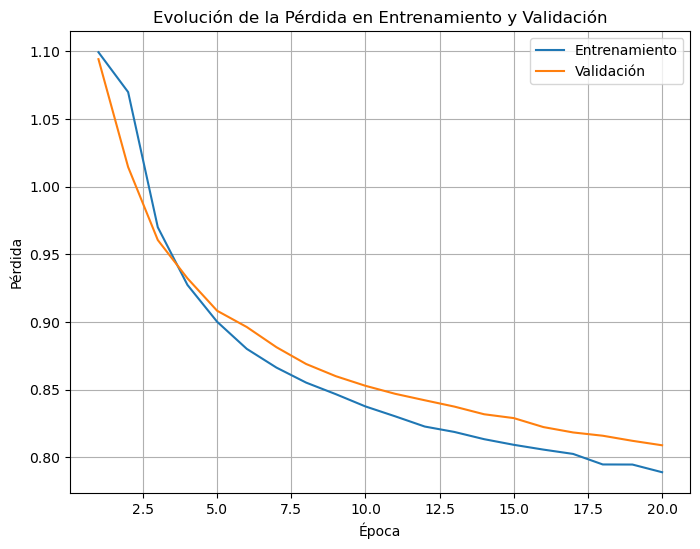

Device: cpu


 35%|███▌      | 7/20 [01:35<02:57, 13.66s/it, loss=0.794]


KeyboardInterrupt: 

In [ ]:
import os
from src.trainers.train_lstm import train_lstm
from src.trainers.utils import show_loss_val_curves, save_model_torch
from constants.constants_tiktok import LSTM_LOSS_CURVES_DIR, TIKTOK_LSTM_METRICS_PATH, LSTM_MODEL_PATH, EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

for optim in list_optim:
    for lr in list_lr:
        cont = 0
        model, metrics, train_losses, val_losses = train_lstm(
            dataset_train=dataset_train_tokenized,
            dataset_val=dataset_val_tokenized,
            embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
            model_args=model_args,
            early_stopping = EarlyStopping(patience, min_delta), # reinicio
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            optim=optim,
            use_class_weights=True
        )
        print(f"[LSTM {optim} {lr:.5f} {model_args.dropout}] acc: {metrics['accuracy']:.4f}")
        save_metrics(metrics, TIKTOK_LSTM_METRICS_PATH)
        title = f"LSTM {metrics['optim']} {'-'.join(str(lr).split('.'))}"
        path = os.path.join(LSTM_LOSS_CURVES_DIR, f"{title}_{str(cont)}.png")
        show_loss_val_curves(train_losses, val_losses, len(train_losses))
        if metrics['accuracy'] > best_accuracy:
            best_accuracy = metrics['accuracy']
            save_model_torch(model.get_model(), LSTM_MODEL_PATH)

## Modelo con mayor accuracy

In [7]:
import pandas as pd

# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_LSTM_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy           0.335146
recall             0.335146
precision            0.3353
f1_score           0.335144
model                  LSTM
optim                  adam
lr                   0.0001
patience                NaN
min_delta            0.0001
rnn_layers                2
hidden_size               2
dropout                 0.2
epochs                   20
batch_size               64
embedding_dim           100
train_time       252.916827
Name: 0, dtype: object


In [ ]:
from src.trainers.utils import ModelArgs, load_model_torch
from constants.constants_tiktok import LSTM_MODEL_PATH
from src.trainers.trainer_rnn import evaluate_model
from src.trainers.train_lstm import LSTMMOdel


batch_size = 64
model_args = ModelArgs()
model_args.input_size = best_acc['embedding_dim']
model_args.hidden_size = int(best_acc['hidden_size'])
model_args.num_layers = int(best_acc['num_layers'])
model_args.output_size = 3
model_args.dropout = best_acc['dropout']

model = LSTMMOdel(model_args)
model = load_model_torch(model, LSTM_MODEL_PATH)

metrics = evaluate_model(
    model,
    dataset_test_tokenized,
    "LSTM",
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    batch_size,
)
display(metrics)

In [ ]:
from src.trainers.train_lstm import LSTMModel
from constants.constants_tiktok import LSTM_MODEL_PATH
from src.trainers.utils import load_model_torch
from src.trainers.train_rnn import SentimentAnalysis

from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

model = LSTMModel(model_args)
model = load_model_torch(model, LSTM_MODEL_PATH)
cls = SentimentAnalysis(model, tokenizer, EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,"cpu")

In [ ]:

from src.preprocesamiento.clean import clean_text
from src.preprocesamiento.nlp_spacy import preprocesamiento

textos_test = ["Hola! cómo estás???😀","el dia de hoy estoy feliz y contento", "estoy muy triste", "Me encuentro estudiando para un exámen", "A veces me encuentro triste, pero la mayoria del tiempo estoy muy feliz"]
textos_test = list(map(lambda x: clean_text(x), textos_test))
textos_test = preprocesamiento(textos_test)
for texto in textos_test:
    print(cls.predict(texto))